In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import time
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from models import efficientnet, craft, smallnet, transformer
import crafte2e_dataset, craft_util, losses

In [2]:
ROOT_PATH = '.'#'/content/gdrive/My Drive/project/craft
vocab = {}
rev_vocab = {}
with open(os.path.join(ROOT_PATH, 'vocab.txt'), 'r', encoding='UTF8') as f:
    lines = f.readlines()
    for line_ind, line in enumerate(lines):
        line = line.rstrip()
        if len(line) == 0:
            continue
        ch = line.split('\t')[0]
        vocab[ch] = line_ind
        rev_vocab[line_ind] = ch

INIT PARAMS

In [3]:
BATCH_SIZE = 1
num_epochs = 40
init_lr = 1e-4
input_shape = (1440, 1440, 3)
input_shape1 = (64, 90, 80)
max_boxes = 200
max_char = 50
vocab_size = len(vocab)

BUILD DATASET

In [4]:
dataset = crafte2e_dataset.Dataset(os.path.join(ROOT_PATH, 'dataset/train/gts'), vocab, max_boxes, max_char)
def get_dataset(batch_size, is_training=True):
    tfdataset = tf.data.Dataset.from_generator(dataset.generate,
                                            (tf.int32),
                                            (tf.TensorShape([])))
    def tf_numpy_fn(index):
        tf_image, tf_char, tf_aff, tf_labels, tf_boxes, tf_quad_boxes = tf.numpy_function(dataset.process,
                                                        [index],
                                                        [tf.float32, tf.float32, tf.float32, tf.int32, tf.float32, tf.float32])
        tf_image.set_shape([1440,1440,3])
        tf_char.set_shape([720,720])
        tf_aff.set_shape([720,720])
        tf_labels.set_shape([max_boxes, max_char])
        tf_boxes.set_shape([max_boxes, 4])
        tf_quad_boxes.set_shape([max_boxes, 4,2])
        return tf_image, tf_char, tf_aff, tf_labels, tf_boxes, tf_quad_boxes
    tfdataset = tfdataset.map(tf_numpy_fn)#, num_parallel_calls=16)
    if is_training:
        tfdataset = tfdataset.repeat()
    tfdataset = tfdataset.batch(batch_size, drop_remainder=True)
    return tfdataset
if 0:
    per_replica_batch_size = BATCH_SIZE // strategy.num_replicas_in_sync
    train_dataset = strategy.experimental_distribute_datasets_from_function(lambda _: get_dataset(per_replica_batch_size, is_training=True))
else:
    train_dataset = get_dataset(BATCH_SIZE, is_training=True)

BUILD OPTIMIZER & MODEL

In [5]:
optimizer = tf.keras.optimizers.Adam(init_lr)
backbone_model = efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
craft_model = craft.CRAFT()
for layer in backbone_model.layers:
    layer.trainable=False
for layer in craft_model.layers:
    layer.trainable=False
resnet = smallnet.Resnet()
trfmer = transformer.Transformer(target_vocab_size=vocab_size)
focal_loss = losses.focal()

BUILD CKPT

In [6]:
ckpt = tf.train.Checkpoint(backbone=backbone_model, craft=craft_model, smallresnet=resnet, transformer=trfmer)
manager = tf.train.CheckpointManager(ckpt, os.path.join(ROOT_PATH, 'summaries/crafte2e2'), max_to_keep=3)

BUILD TRAIN FUNC

In [7]:
# def train_step(iterator):
@tf.function
def det(inputs):
    image = inputs        
    backbone_features = backbone_model(image)
    y, features = craft_model(backbone_features)
    return y, features

@tf.function
def extract_features(inputs):
    image, features, boxes, char_mask, aff_mask, quad_boxes = inputs
    if 0:
        boxes = np.zeros((BATCH_SIZE, max_boxes, 4), np.float32)
        quad_boxes = np.zeros((BATCH_SIZE, max_boxes, 4, 2), np.float32)
        box_indices = np.zeros((BATCH_SIZE, max_boxes), np.int32)
        for batch_ind, (text_map, aff_map) in enumerate(zip(char_mask.numpy(), aff_mask.numpy())):
            det_boxes = craft_util.getDetBoxes(text_map,
                                                aff_map,
                                                text_threshold=0.2,
                                                link_threshold=0.2,
                                                low_text=0.2)
            det_boxes = np.array(det_boxes, np.float32) / (input_shape[0]//2)
            num_det_boxes = len(det_boxes)
            boxes[batch_ind, :num_det_boxes, 0] = det_boxes[:, 0, 1]
            boxes[batch_ind, :num_det_boxes, 1] = det_boxes[:, 0, 0]
            boxes[batch_ind, :num_det_boxes, 2] = det_boxes[:, 2, 1]
            boxes[batch_ind, :num_det_boxes, 3] = det_boxes[:, 2, 0]
            quad_boxes[batch_ind, :num_det_boxes, :, 0] = det_boxes[:,:,1]
            quad_boxes[batch_ind, :num_det_boxes, :, 1] = det_boxes[:,:,0]
            box_indices[batch_ind, :] = batch_ind
        boxes = tf.reshape(tf.convert_to_tensor(boxes, tf.float32), [BATCH_SIZE*max_boxes, 4])
        box_indices = tf.reshape(tf.convert_to_tensor(box_indices, tf.int32), [BATCH_SIZE*max_boxes])
    elif 1:
#         np_imgs = image.numpy()
#         np_features = features.numpy()
#         features_shape = np_features.shape
#         np_quad_boxes = quad_boxes.numpy()
#         np_boxes = boxes.numpy()
#         tmp_features = np.zeros([BATCH_SIZE, max_boxes, input_shape1[0], input_shape1[1], input_shape1[2]], np.float32)
#         tmp_imgs = np.zeros([BATCH_SIZE, max_boxes, input_shape1[0], input_shape1[1], 3], np.float32)
        def batch_crop_fn(_inputs):
            _features, _crop_boxes, _q_boxes = _inputs
            
            def warp_features_fn(__inputs):
                _crop_box, _q_box = __inputs
                _crop_box = tf.cast(_crop_box*_features.shape[0], tf.int32)
                y1 = _crop_box[0]
                x1 = _crop_box[1]
                y2 = _crop_box[2]
                x2 = _crop_box[3]
                crop_feature = _features[y1:y2, x1:x2]
                _q_box = _q_box *_features.shape[0]
                
                def my_numpy_func(np_x1, np_y1, np_q_box, np_crop_feature):
#                     np_q_box, np_crop_feature = ___inputs
#                     
                    if np.sum(np_q_box) == 0 or np_crop_feature.shape[0] == 0 or np_crop_feature.shape[1] == 0:
                        return np.zeros((input_shape1[0], input_shape1[1], np_crop_feature.shape[2]), np.float32)
                    else:
                        np_q_box[:,0] -= np_x1
                        np_q_box[:,1] -= np_y1
                        pts1 = np.array([np_q_box[0],
                                         np_q_box[1],
                                         np_q_box[3],
                                         np_q_box[2]], dtype="float32")
                        pts2 = np.array([[0, 0],
                                        [input_shape1[1] - 1, 0],
                                        [0, input_shape1[0] - 1],
                                        [input_shape1[1] - 1, input_shape1[0] - 1]], dtype="float32")
                        M = cv2.getPerspectiveTransform(pts1, pts2)
                        return cv2.warpPerspective(np_crop_feature, M, (input_shape1[1], input_shape1[0]))
                
                __warp_features = tf.numpy_function(my_numpy_func, [x1, y1, _q_box, crop_feature], tf.float32)
                __warp_features.set_shape([input_shape1[0], input_shape1[1], _features.shape[2]])
                return __warp_features
            
            _warp_features = tf.map_fn(warp_features_fn, [_crop_boxes, _q_boxes], fn_output_signature=tf.float32)
            return _warp_features
        img_feature = tf.map_fn(batch_crop_fn, [features, boxes, quad_boxes], fn_output_signature=tf.float32)
        crop_images = tf.map_fn(batch_crop_fn, [image, boxes, quad_boxes], fn_output_signature=tf.float32)
        img_feature = tf.reshape(img_feature, [BATCH_SIZE*max_boxes, input_shape1[0], input_shape1[1], input_shape1[2]])
        crop_images = tf.reshape(crop_images, [BATCH_SIZE*max_boxes, input_shape1[0], input_shape1[1], 3])
#         for batch_i in range(BATCH_SIZE):
#             batch_feature = np_features[batch_i]
#             batch_image = np_imgs[batch_i]
#             for iter_i in range(max_boxes):
#                 crop_box = np_boxes[batch_i, iter_i]*features_shape[1]
#                 crop_box = crop_box.astype(np.int32)
#                 y1, x1, y2, x2 = crop_box
#                 crop_feature = batch_feature[y1:y2, x1:x2]
#                 q_boxes = np_quad_boxes[batch_i, iter_i]*features_shape[1]
#                 if np.sum(q_boxes) == 0 or crop_feature.shape[0] == 0 or crop_feature.shape[1] == 0:
#                     continue
#                 q_boxes[:,0] -= x1
#                 q_boxes[:,1] -= y1
#                 pts1 = np.array([q_boxes[0],
#                                  q_boxes[1],
#                                  q_boxes[3],
#                                  q_boxes[2]], dtype="float32")
#                 pts2 = np.array([[0, 0],
#                                 [input_shape1[1] - 1, 0],
#                                 [0, input_shape1[0] - 1],
#                                 [input_shape1[1] - 1, input_shape1[0] - 1]], dtype="float32")
#                 M = cv2.getPerspectiveTransform(pts1, pts2)
#                 tmp_features[batch_i, iter_i] = cv2.warpPerspective(crop_feature, M, (input_shape1[1], input_shape1[0]))
#             for iter_i in range(max_boxes):
#                 crop_box = np_boxes[batch_i, iter_i]*np_imgs.shape[1]
#                 crop_box = crop_box.astype(np.int32)
#                 print(crop_box)
#                 y1, x1, y2, x2 = crop_box
#                 crop_feature = batch_image[y1:y2, x1:x2]
#                 plt.imshow((((crop_feature * dataset.std) + dataset.mean)*255.0).astype(np.uint8))
#                 plt.show()
#                 q_boxes = np_quad_boxes[batch_i, iter_i]*np_imgs.shape[1]
#                 if np.sum(q_boxes) == 0 or crop_feature.shape[0] == 0 or crop_feature.shape[1] == 0:
#                     continue
#                 q_boxes[:,0] -= x1
#                 q_boxes[:,1] -= y1
#                 pts1 = np.array([q_boxes[0],
#                                  q_boxes[1],
#                                  q_boxes[3],
#                                  q_boxes[2]], dtype="float32")
#                 pts2 = np.array([[0, 0],
#                                 [input_shape1[1] - 1, 0],
#                                 [0, input_shape1[0] - 1],
#                                 [input_shape1[1] - 1, input_shape1[0] - 1]], dtype="float32")
                
#                 M = cv2.getPerspectiveTransform(pts1, pts2)
#                 tmp_imgs[batch_i, iter_i] = cv2.warpPerspective(crop_feature, M, (input_shape1[1], input_shape1[0]))
# #                 plt.imshow((((tmp_imgs[batch_i, iter_i] * dataset.std) + dataset.mean)*255.0).astype(np.uint8))
# #                 plt.show()
# #                 assert False
#         img_feature = tf.convert_to_tensor(tmp_features.reshape(BATCH_SIZE*max_boxes, input_shape1[0], input_shape1[1], input_shape1[2]), tf.float32)
#         crop_images = tf.convert_to_tensor(tmp_imgs.reshape(BATCH_SIZE*max_boxes, input_shape1[0], input_shape1[1], 3), tf.float32)
    else:
        box_indices = tf.transpose(tf.reshape(tf.tile(tf.range(BATCH_SIZE),[max_boxes]), [max_boxes,BATCH_SIZE]), [1,0])
        box_indices = tf.reshape(box_indices, [BATCH_SIZE*max_boxes])
#         box_indices = np.zeros((BATCH_SIZE, max_boxes), np.int32)
#         for batch_ind in range(BATCH_SIZE):
#             box_indices[batch_ind, :] = batch_ind
        boxes = tf.reshape(boxes, [BATCH_SIZE*max_boxes, 4])
#         box_indices = tf.reshape(tf.convert_to_tensor(box_indices, tf.int32), [BATCH_SIZE*max_boxes])
        img_feature = tf.image.crop_and_resize(features,
                                                boxes=boxes,
                                                box_indices=box_indices,
                                                crop_size=[input_shape1[0], input_shape1[1]])
        crop_images = tf.image.crop_and_resize(image,
                                                boxes=boxes,
                                                box_indices=box_indices,
                                                crop_size=[input_shape1[0], input_shape1[1]])
    return img_feature, crop_images

@tf.function
def step_fn(inputs):
    img_features, labels = inputs
    with tf.GradientTape() as tape:
        img_features = resnet(img_features, training=True)
        img_features_shape = img_features.shape
        img_features = tf.transpose(img_features, [0, 2, 1, 3])
        img_features = tf.reshape(img_features, [img_features_shape[0], img_features_shape[1] * img_features_shape[2], img_features_shape[3]])
        img_features_mask = tf.ones([img_features_shape[0], img_features_shape[1] * img_features_shape[2]])
        labels = tf.reshape(labels, [img_features_shape[0], max_char])
        tar_input = labels[:, :-1]
        tar_real = labels[:, 1:]
        enc_padding_mask, combined_mask, dec_padding_mask = transformer.create_masks(img_features_mask, tar_input)
        outputs, attention_weights = trfmer(img_features, tar_input, True, enc_padding_mask, combined_mask, dec_padding_mask)
        outputs = tf.math.softmax(outputs)
        mask = tf.cast(tf.greater(tar_real, 0), tf.int32)
        tar_real_onehot = tf.one_hot(tar_real, depth=vocab_size)
        loss_value = focal_loss(y_true=tar_real_onehot,
                                            y_pred=outputs,
                                            y_mask=mask)
    
        trainable_weights = resnet.trainable_weights + trfmer.trainable_weights
    grads = tape.gradient(loss_value, trainable_weights)
    optimizer.apply_gradients(zip(grads, trainable_weights))
    return [loss_value, outputs, tar_real]
    # if 0:
    #     strategy.run(step_fn, args=(next(iterator),))

RESTORE

In [8]:
steps = 0
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
    ckpt.restore(manager.latest_checkpoint)
    steps = int(manager.latest_checkpoint.split('-')[1])
else:
    ckpt = tf.train.Checkpoint(backbone=backbone_model, craft=craft_model)#, transformer=trfmer)
    ckpt.restore(os.path.join(ROOT_PATH, 'summaries/crafte2e/ckpt-12000'))
    print("Initializing from scratch.")

Initializing from scratch.


START TRAIN

W0920 15:22:36.649562 140282964145984 deprecation.py:506] From /home/jylim2/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:574: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


epoch: 0,	steps: 0,	loss: 1.95,	fn_time: 34.01


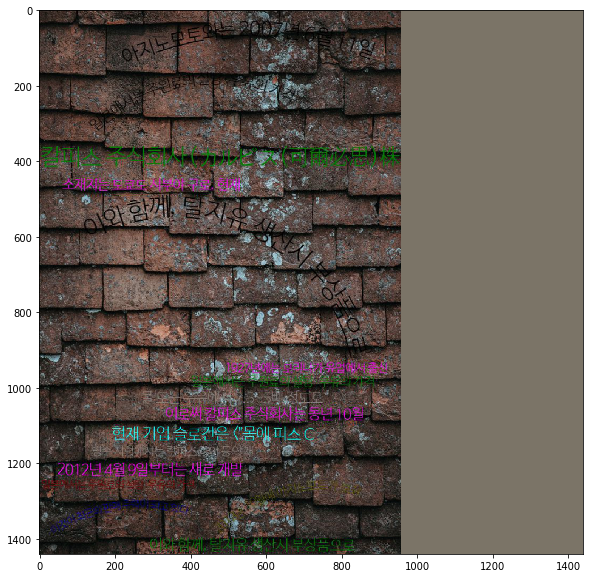

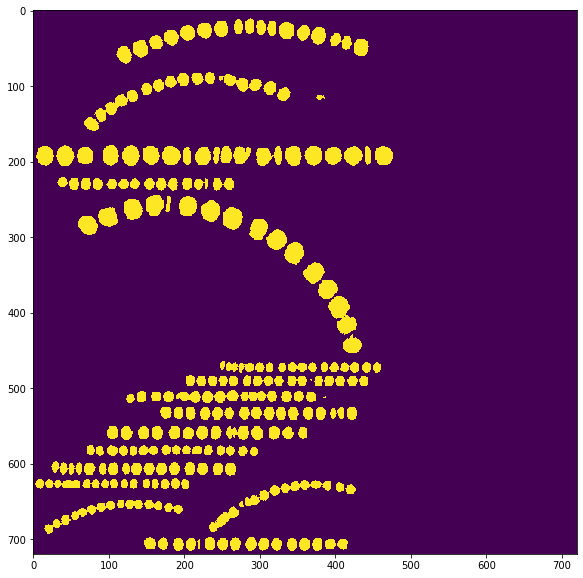

(64, 90, 3)


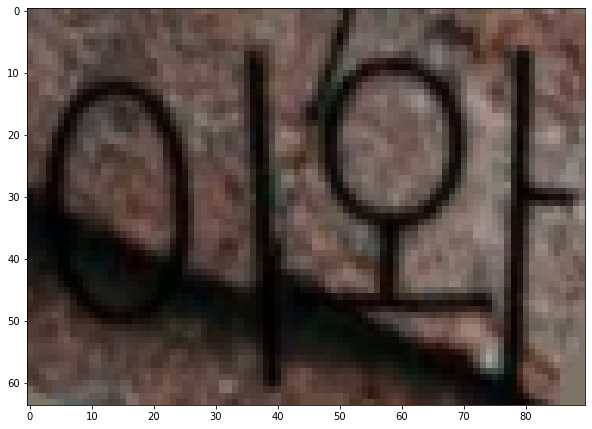

(200, 49)
	gt:	 이와
epoch: 0,	steps: 0,	loss: 1.82,	fn_time: 29.27


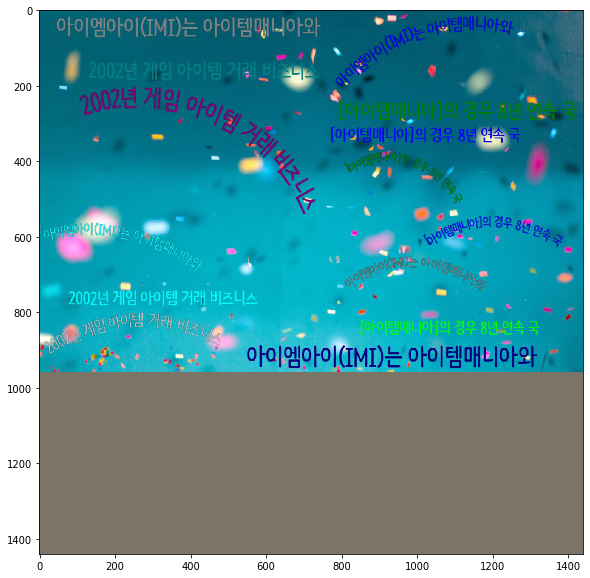

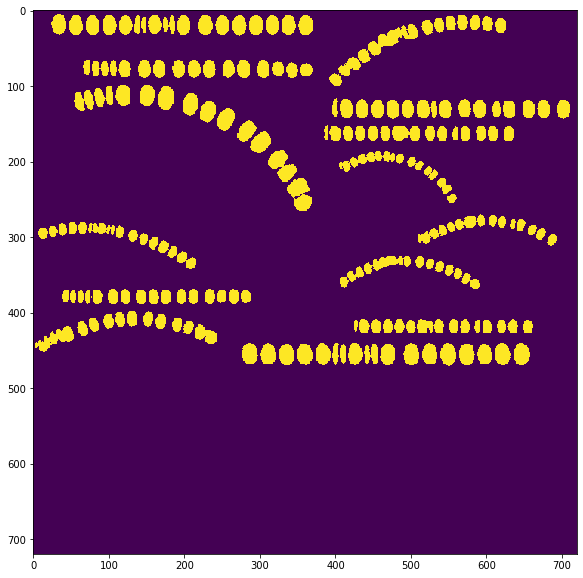

(64, 90, 3)


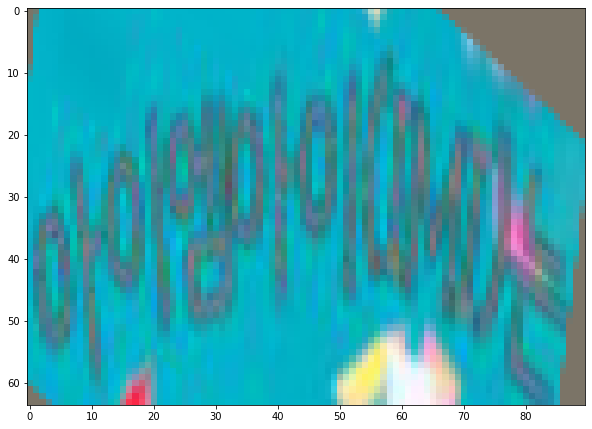

(200, 49)
	gt:	 아이엠아이(imi)는
	pred:	 출


KeyboardInterrupt: 

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

num_dataset = 3000#len(dataset.gt_path_ind)
iterator = iter(train_dataset)

for epoch_i in  range(num_epochs):
    sum_time = 0
    for iter_i in range(10):#num_dataset//BATCH_SIZE):
        # loss = train_step(iterator)
        start_time = time.time()
        image, char, aff, labels, bboxes, quad_boxes = next(iterator)
        y, features = det(image)
        img_features, crop_images = extract_features([image, features, bboxes, char, aff, quad_boxes])
        loss, _preds, _labels = step_fn([img_features, labels])
        end_time = time.time()
        sum_time += (end_time - start_time)
        if 1:#steps % 100 == 0:            
            print("epoch: {:d},\tsteps: {:d},\tloss: {:1.2f},\tfn_time: {:1.2f}".format(epoch_i, steps, loss.numpy(), sum_time/(iter_i+1)))
            if 1:
                np_image = image[0].numpy()
                np_image = (((np_image * dataset.std) + dataset.mean)*255.0).astype(np.uint8)
                plt.imshow(np_image)
                plt.show()
                mask = tf.cast(tf.greater(y[0,:,:,0], 0.05), tf.float32)
                plt.imshow(mask.numpy())
                plt.show()
                crop_images = crop_images[0].numpy()
                print(crop_images.shape)
                crop_images = (((crop_images * dataset.std) + dataset.mean)*255.0).astype(np.uint8)
                plt.imshow(crop_images)
                plt.show()
                print(_labels.shape)

            gt = _labels[0].numpy()
            txt = []
            eos_ind = np.where(gt == 2)[0] 
            for ch_id in gt[:eos_ind[0]]:
                ch = rev_vocab[ch_id]
                txt.append(ch)
            print("\tgt:\t",''.join(txt)) 
            pred = np.argmax(_preds[0].numpy(), axis=-1)
            txt = []
            eos_ind = np.where(pred == 2)[0]
            if len(eos_ind) > 0:
                for ch_id in pred[:eos_ind[0]]:
                    ch = rev_vocab[ch_id]
                    txt.append(ch)            
                print("\tpred:\t",''.join(txt))
            
#             assert False
#         steps += 1
#     save_path = manager.save(steps)
#     print("Saved checkpoint for step {}: {}".format(steps, save_path))

In [ ]:
# def train_step(iterator):
@tf.function
def det(inputs):
    image = inputs        
    backbone_features = backbone_model(image)
    y, features = craft_model(backbone_features)
    return y, features

def extract_features(inputs):
    image, features, boxes, char_mask, aff_mask, quad_boxes = inputs
    if 0:
        boxes = np.zeros((BATCH_SIZE, max_boxes, 4), np.float32)
        quad_boxes = np.zeros((BATCH_SIZE, max_boxes, 4, 2), np.float32)
        box_indices = np.zeros((BATCH_SIZE, max_boxes), np.int32)
        for batch_ind, (text_map, aff_map) in enumerate(zip(char_mask.numpy(), aff_mask.numpy())):
            det_boxes = craft_util.getDetBoxes(text_map,
                                                aff_map,
                                                text_threshold=0.2,
                                                link_threshold=0.2,
                                                low_text=0.2)
            det_boxes = np.array(det_boxes, np.float32) / (input_shape[0]//2)
            num_det_boxes = len(det_boxes)
            boxes[batch_ind, :num_det_boxes, 0] = det_boxes[:, 0, 1]
            boxes[batch_ind, :num_det_boxes, 1] = det_boxes[:, 0, 0]
            boxes[batch_ind, :num_det_boxes, 2] = det_boxes[:, 2, 1]
            boxes[batch_ind, :num_det_boxes, 3] = det_boxes[:, 2, 0]
            quad_boxes[batch_ind, :num_det_boxes, :, 0] = det_boxes[:,:,1]
            quad_boxes[batch_ind, :num_det_boxes, :, 1] = det_boxes[:,:,0]
            box_indices[batch_ind, :] = batch_ind
        boxes = tf.reshape(tf.convert_to_tensor(boxes, tf.float32), [BATCH_SIZE*max_boxes, 4])
        box_indices = tf.reshape(tf.convert_to_tensor(box_indices, tf.int32), [BATCH_SIZE*max_boxes])
    elif 1:
        np_imgs = image.numpy()
        np_features = features.numpy()
        features_shape = np_features.shape
        np_quad_boxes = quad_boxes.numpy()
        np_boxes = boxes.numpy()
        tmp_features = np.zeros([BATCH_SIZE, max_boxes, input_shape1[0], input_shape1[1], input_shape1[2]], np.float32)
        tmp_imgs = np.zeros([BATCH_SIZE, max_boxes, input_shape1[0], input_shape1[1], 3], np.float32)
        for batch_i in range(BATCH_SIZE):
            batch_feature = np_features[batch_i]
            batch_image = np_imgs[batch_i]
            for iter_i in range(max_boxes):
                crop_box = np_boxes[batch_i, iter_i]*features_shape[1]
                crop_box = crop_box.astype(np.int32)
                y1, x1, y2, x2 = crop_box
                crop_feature = batch_feature[y1:y2, x1:x2]
                q_boxes = np_quad_boxes[batch_i, iter_i]*features_shape[1]
                if np.sum(q_boxes) == 0 or crop_feature.shape[0] == 0 or crop_feature.shape[1] == 0:
                    continue
                q_boxes[:,0] -= x1
                q_boxes[:,1] -= y1
                pts1 = np.array([q_boxes[0],
                                 q_boxes[1],
                                 q_boxes[3],
                                 q_boxes[2]], dtype="float32")
                pts2 = np.array([[0, 0],
                                [input_shape1[1] - 1, 0],
                                [0, input_shape1[0] - 1],
                                [input_shape1[1] - 1, input_shape1[0] - 1]], dtype="float32")
                M = cv2.getPerspectiveTransform(pts1, pts2)
                tmp_features[batch_i, iter_i] = cv2.warpPerspective(crop_feature, M, (input_shape1[1], input_shape1[0]))
            for iter_i in range(max_boxes):
                crop_box = np_boxes[batch_i, iter_i]*np_imgs.shape[1]
                crop_box = crop_box.astype(np.int32)
                print(crop_box)
                y1, x1, y2, x2 = crop_box
                crop_feature = batch_image[y1:y2, x1:x2]
#                 plt.imshow((((crop_feature * dataset.std) + dataset.mean)*255.0).astype(np.uint8))
#                 plt.show()
                q_boxes = np_quad_boxes[batch_i, iter_i]*np_imgs.shape[1]
                if np.sum(q_boxes) == 0 or crop_feature.shape[0] == 0 or crop_feature.shape[1] == 0:
                    continue
                q_boxes[:,0] -= x1
                q_boxes[:,1] -= y1
                pts1 = np.array([q_boxes[0],
                                 q_boxes[1],
                                 q_boxes[3],
                                 q_boxes[2]], dtype="float32")
                pts2 = np.array([[0, 0],
                                [input_shape1[1] - 1, 0],
                                [0, input_shape1[0] - 1],
                                [input_shape1[1] - 1, input_shape1[0] - 1]], dtype="float32")
                
                M = cv2.getPerspectiveTransform(pts1, pts2)
                tmp_imgs[batch_i, iter_i] = cv2.warpPerspective(crop_feature, M, (input_shape1[1], input_shape1[0]))
#                 plt.imshow((((tmp_imgs[batch_i, iter_i] * dataset.std) + dataset.mean)*255.0).astype(np.uint8))
#                 plt.show()
#                 assert False
        img_feature = tf.convert_to_tensor(tmp_features.reshape(BATCH_SIZE*max_boxes, input_shape1[0], input_shape1[1], input_shape1[2]), tf.float32)
        crop_images = tf.convert_to_tensor(tmp_imgs.reshape(BATCH_SIZE*max_boxes, input_shape1[0], input_shape1[1], 3), tf.float32)
    else:
        box_indices = tf.transpose(tf.reshape(tf.tile(tf.range(BATCH_SIZE),[max_boxes]), [max_boxes,BATCH_SIZE]), [1,0])
        box_indices = tf.reshape(box_indices, [BATCH_SIZE*max_boxes])
#         box_indices = np.zeros((BATCH_SIZE, max_boxes), np.int32)
#         for batch_ind in range(BATCH_SIZE):
#             box_indices[batch_ind, :] = batch_ind
        boxes = tf.reshape(boxes, [BATCH_SIZE*max_boxes, 4])
#         box_indices = tf.reshape(tf.convert_to_tensor(box_indices, tf.int32), [BATCH_SIZE*max_boxes])
        img_feature = tf.image.crop_and_resize(features,
                                                boxes=boxes,
                                                box_indices=box_indices,
                                                crop_size=[input_shape1[0], input_shape1[1]])
        crop_images = tf.image.crop_and_resize(image,
                                                boxes=boxes,
                                                box_indices=box_indices,
                                                crop_size=[input_shape1[0], input_shape1[1]])
    return img_feature, crop_images

@tf.function
def step_fn(inputs):
    img_features, labels = inputs
    with tf.GradientTape() as tape:
        img_features = resnet(img_features, training=True)
        img_features_shape = img_features.shape
        img_features = tf.transpose(img_features, [0, 2, 1, 3])
        img_features = tf.reshape(img_features, [img_features_shape[0], img_features_shape[1] * img_features_shape[2], img_features_shape[3]])
        img_features_mask = tf.ones([img_features_shape[0], img_features_shape[1] * img_features_shape[2]])
        labels = tf.reshape(labels, [img_features_shape[0], max_char])
        tar_input = labels[:, :-1]
        tar_real = labels[:, 1:]
        enc_padding_mask, combined_mask, dec_padding_mask = transformer.create_masks(img_features_mask, tar_input)
        outputs, attention_weights = trfmer(img_features, tar_input, True, enc_padding_mask, combined_mask, dec_padding_mask)
        outputs = tf.math.softmax(outputs)
        mask = tf.cast(tf.greater(tar_real, 0), tf.int32)
        tar_real_onehot = tf.one_hot(tar_real, depth=vocab_size)
        loss_value = focal_loss(y_true=tar_real_onehot,
                                            y_pred=outputs,
                                            y_mask=mask)
    
        trainable_weights = resnet.trainable_weights + trfmer.trainable_weights
    grads = tape.gradient(loss_value, trainable_weights)
    optimizer.apply_gradients(zip(grads, trainable_weights))
    return [loss_value, outputs, tar_real]
    # if 0:
    #     strategy.run(step_fn, args=(next(iterator),))

In [ ]:
aa = tf.transpose(tf.reshape(tf.tile(tf.range(2),[100]), [100,2]), [1,0])
print(aa)
print(tf.reshape(aa, [200]))